# Tfidf word2vec featured models
- **Tuned Hyperparameters of models**
- **rectified minor mistakes in code**

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

import sqlite3
from sqlalchemy import create_engine # database connection

import os
from scipy import stats
from scipy.stats import randint as sp_randint
from scipy.sparse import hstack

import datetime as dt
import numpy as np
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

from sklearn.calibration import CalibratedClassifierCV

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDClassifier

<h1>4. Machine Learning Models </h1>

<h2> 4.1 Reading data from file and storing into sql table </h2>

In [3]:
feat_names_lst =['Unnamed: 0','id','is_duplicate','cwc_min','cwc_max','csc_min','csc_max','ctc_min','ctc_max',
                'last_word_eq','first_word_eq','abs_len_diff','mean_len','token_set_ratio','token_sort_ratio',
                'fuzz_ratio','fuzz_partial_ratio','longest_substr_ratio','freq_qid1', 'freq_qid2', 'q1len', 'q2len',
                'q1_n_words', 'q2_n_words', 'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2']

q1_feat_names =[]
q2_feat_names =[]

for ii in range(384):
    c_x = str(ii)+'_x'
    q1_feat_names.append(c_x)
    c_y = str(ii)+'_y'
    q2_feat_names.append(c_y) 

feat_name = feat_names_lst + q1_feat_names + q2_feat_names
print(feat_name)


['Unnamed: 0', 'id', 'is_duplicate', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len', 'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio', 'fuzz_partial_ratio', 'longest_substr_ratio', 'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2', '0_x', '1_x', '2_x', '3_x', '4_x', '5_x', '6_x', '7_x', '8_x', '9_x', '10_x', '11_x', '12_x', '13_x', '14_x', '15_x', '16_x', '17_x', '18_x', '19_x', '20_x', '21_x', '22_x', '23_x', '24_x', '25_x', '26_x', '27_x', '28_x', '29_x', '30_x', '31_x', '32_x', '33_x', '34_x', '35_x', '36_x', '37_x', '38_x', '39_x', '40_x', '41_x', '42_x', '43_x', '44_x', '45_x', '46_x', '47_x', '48_x', '49_x', '50_x', '51_x', '52_x', '53_x', '54_x', '55_x', '56_x', '57_x', '58_x', '59_x', '60_x', '61_x', '62_x', '63_x', '64_x', '65_x', '66_x', '67_x', '68_x', '69_x', '70_x', '71_x', '72_x', '73_x', '74_x', '75_

In [4]:
#Creating db file from csv
if not os.path.isfile('train.db'):
    disk_engine = create_engine('sqlite:///train.db')
    start = dt.datetime.now()
    chunksize = 180000
    j = 0
    index_start = 1
    for df in pd.read_csv('final_features.csv', names= feat_name,chunksize=chunksize, iterator=True, encoding='utf-8',):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1

In [5]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None


def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

In [6]:
read_db = 'train.db'
conn_r = create_connection(read_db)
checkTableExists(conn_r)
conn_r.close()

Tables in the databse:
data


In [7]:
# try to sample data according to the computing power you have
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        # for selecting first 1M rows
        # data = pd.read_sql_query("""SELECT * FROM data LIMIT 100001;""", conn_r)
        
        # for selecting random points
        data = pd.read_sql_query("SELECT * From data ORDER BY RANDOM() LIMIT 100001;", conn_r)
        conn_r.commit()
        conn_r.close()

In [9]:
data.head()

,index,Unnamed: 0,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,...,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
0,168723,168721.0,168721,0,0.999950002499875,0.999950002499875,0.799984000319994,0.666655555740738,0.857130612419823,0.749990625117186,...,1.07344778999686,8.01113703474402,6.48343658447266,-3.14867302775383,5.7786565721035,4.8818209245801,-10.2038290351629,4.77338662743568,10.633961379528,0.862086351960897
1,158914,158912.0,158912,0,0.999966667777741,0.999966667777741,0.249993750156246,0.249993750156246,0.571420408279882,0.499993750078124,...,12.9054596424103,4.62867963314056,-7.64878877997398,-3.84721750020981,7.8705914914608,7.69620086252689,-16.3719347119331,13.2070941329002,-2.24652349948883,8.24461363255978
2,18442,18440.0,18440,0,0.249993750156246,0.249993750156246,0.0,0.0,0.111109876556927,0.0999990000099999,...,6.25839075446129,-7.56147272512317,-0.686928194016218,-2.0595915094018,19.5829977989197,9.06717039644718,4.66185779869556,-7.10229784250259,9.63857187330723,3.62664395943284
3,390145,210143.0,210143,0,0.0,0.0,0.333329629670781,0.187498828132324,0.142856462588273,0.0999996666677778,...,20.1712442589924,21.1498776525259,11.4385510012507,-12.3497275486588,41.3848724626005,28.2992212269455,-32.3499974496663,2.5347962975502,9.65986381471157,7.32946795225143
4,539256,359254.0,359254,1,0.66664444518516,0.499987500312492,0.799984000319994,0.499993750078124,0.749990625117186,0.499995833368055,...,-2.50604571402073,-11.8217630088329,7.1784588098526,2.34678238630295,9.79095336049795,6.10408574342728,-3.57294645532966,15.0814106464386,10.6531453933567,4.34491695836186


In [10]:
# remove the first row 
data.drop(data.index[0], inplace=True)
y_true = data['is_duplicate']
data.drop(['Unnamed: 0','id','index','is_duplicate'], axis=1, inplace=True)

<h2> 4.2 Converting strings to numerics </h2>

In [ ]:
# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model
cols = list(data.columns)
for i in cols:
    data[i] = data[i].apply(pd.to_numeric)
    print(i)

In [ ]:
# https://stackoverflow.com/questions/7368789/convert-all-strings-in-a-list-to-int
y_true = list(map(int, y_true.values))

<h2> 4.3 Random train test split( 70:30) </h2>

In [10]:
X_train,X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3)

In [11]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (70000, 794)
Number of data points in test data : (30000, 794)


In [12]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[0])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6314428571428572 Class 1:  0.36855714285714286
---------- Distribution of output variable in test data ----------
Class 0:  0.6314666666666666 Class 1:  0.3685333333333333


In [13]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 4.4 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.8887983032292291


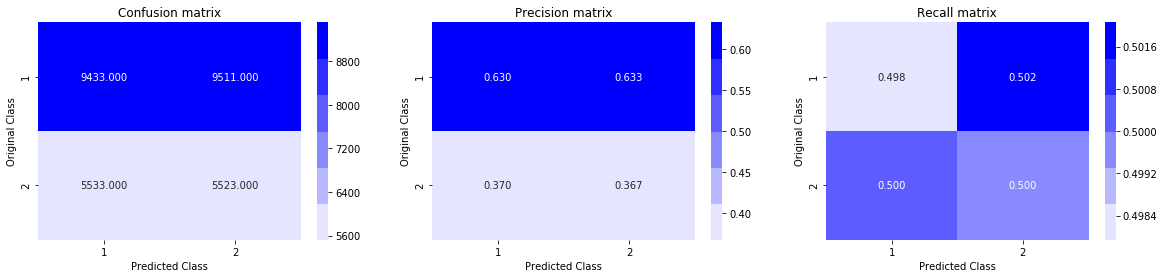

In [18]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.4 Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.6005005508122765
For values of alpha =  0.0001 The log loss is: 0.5175007418411842
For values of alpha =  0.001 The log loss is: 0.5157235875249729
For values of alpha =  0.01 The log loss is: 0.5148346295131943
For values of alpha =  0.1 The log loss is: 0.5295279831100435
For values of alpha =  1 The log loss is: 0.5116179293655119
For values of alpha =  10 The log loss is: 0.5161510289395628


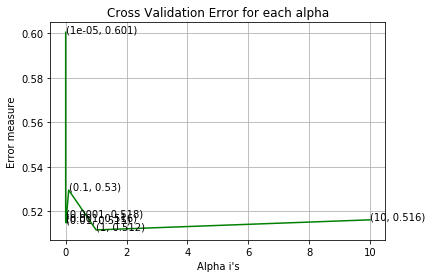

For values of best alpha =  1 The train log loss is: 0.5073495111908511
For values of best alpha =  1 The test log loss is: 0.5116179293655119
Total number of data points : 30000


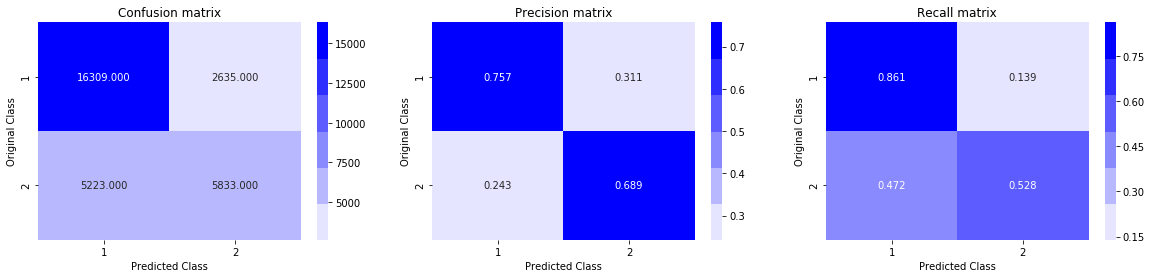

In [25]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.5 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.6581704820028198
For values of alpha =  0.0001 The log loss is: 0.48642549672092167
For values of alpha =  0.001 The log loss is: 0.5202175877554528
For values of alpha =  0.01 The log loss is: 0.5651252674699003
For values of alpha =  0.1 The log loss is: 0.597328615537404
For values of alpha =  1 The log loss is: 0.6331908084935464
For values of alpha =  10 The log loss is: 0.6356885796544999


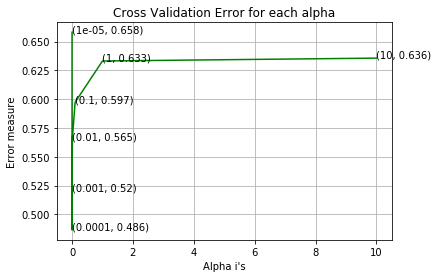

For values of best alpha =  0.0001 The train log loss is: 0.47987288541189366
For values of best alpha =  0.0001 The test log loss is: 0.48642549672092167
Total number of data points : 30000


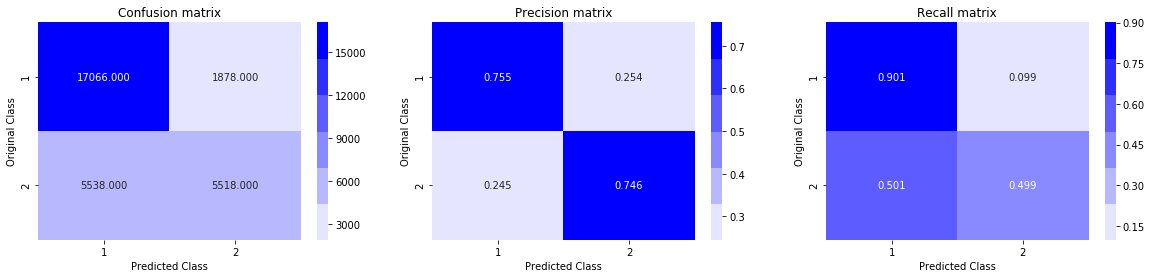

In [26]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.



log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.6 XGBoost </h2>

In [27]:
%%capture
# the metric corresponding to each point is printed, while Xgboost trains
# there is no point in printing thousands of lines in this notebook
# hence i used capture
# it captures all those outputs of the cell,and diverts it to the terminal

import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)


The test log loss is: 0.35399989969918194
Total number of data points : 30000


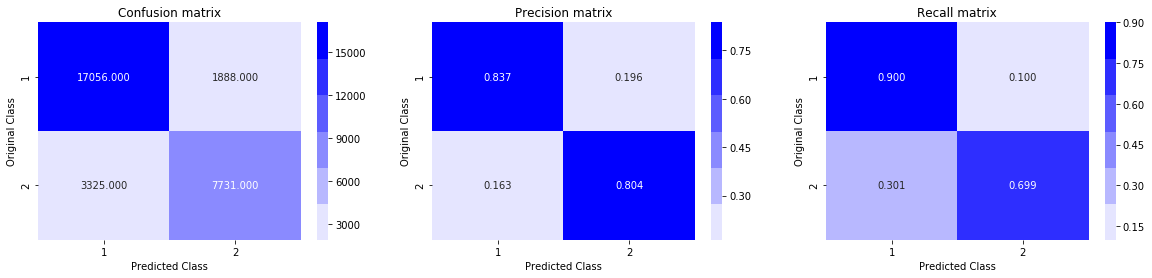

In [28]:
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## 4.7 Randomized search cv Tuned XGBoost

In [37]:
%%capture
# the metric corresponding to each point is printed, while Xgboost trains
# there is no point in printing thousands of lines in this notebook
# hence i used capture
# it captures all those outputs of the cell,and diverts it to the terminal

c_param={
    'learning_rate' :stats.uniform(0.001,0.3),
    'n_estimators':sp_randint(100,1000),
    'max_depth':sp_randint(2,5),
    'min_child_weight':sp_randint(1,8),
    'gamma':stats.uniform(0,0.02),
    'subsample':stats.uniform(0.6,0.4),
    'reg_alpha':sp_randint(0,200),
    'reg_lambda':stats.uniform(0,200),
    'colsample_bytree':stats.uniform(0.6,0.3)}

param={'eval_metric' : 'logloss',
       'eval_set': [(X_train, y_train)],
      'early_stopping_rounds': 10
      }

xclf= xgb.XGBClassifier(n_jobs = -1)

bst_clf = RandomizedSearchCV(xclf, param_distributions= c_param, n_iter=20,n_jobs=-1,
                             fit_params=param,scoring='neg_log_loss', refit=False, verbose=2, cv=3, random_state=42)

bst_clf.fit(X_train, y_train)


In [41]:
print(bst_clf.best_score_)
bst_clf.best_params_

-0.3524076265884464


{'colsample_bytree': 0.8727961206236345,
 'gamma': 0.005175599632000339,
 'learning_rate': 0.1997566853061946,
 'max_depth': 3,
 'min_child_weight': 6,
 'n_estimators': 489,
 'reg_alpha': 53,
 'reg_lambda': 109.34205586865593,
 'subsample': 0.6739417822102108}

In [42]:
%%capture 
# the metric corresponding to each point is printed, while Xgboost trains
# there is no point in printing thousands of lines in this notebook
# hence i used capture
# it captures all those outputs of the cell,and diverts it to the terminal



params = {'colsample_bytree': 0.8727961206236345,
 'gamma': 0.005175599632000339,
 'learning_rate': 0.1997566853061946,
 'max_depth': 3,
 'min_child_weight': 6,
 'n_estimators': 489,
 'reg_alpha': 53,
 'reg_lambda': 109.34205586865593,
 'subsample': 0.6739417822102108}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
#params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)


The test log loss is: 0.34264989693932
Total number of data points : 30000


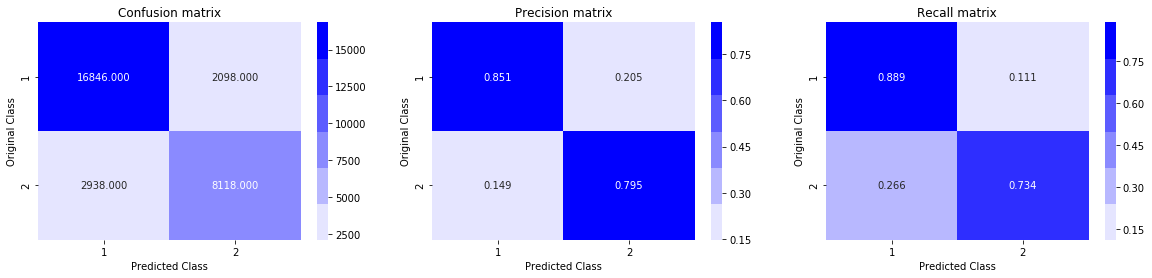

In [44]:
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)